Подключим необходимые модули

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

Мой номер в списке 1 => столбцы 1 и 6 в (0 - индексации).

In [39]:
data = pd.read_csv('../../datasets/students_simple.csv')

N = 1
col1_idx = N % 5
col2_idx = (N**2 % 5) + 5

col1 = data.columns[col1_idx]
col2 = data.columns[col2_idx]

print(f"Выбранные столбцы: {col1} и {col2}")

x = data[col1].dropna().values
y = data[col2].dropna().values

Выбранные столбцы: mass и bmi


Корреляция Фехнера

In [40]:
def fechner_correlation(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    x_sign = np.sign(x - x_mean)
    y_sign = np.sign(y - y_mean)
    
    matches = np.sum(x_sign == y_sign)
    mismatches = np.sum(x_sign != y_sign)
    
    K = (matches - mismatches) / len(x)
    return K

K_fech = fechner_correlation(x, y)
print(f"Корреляция Фехнера: {K_fech:.4f}")

Корреляция Фехнера: -0.9000


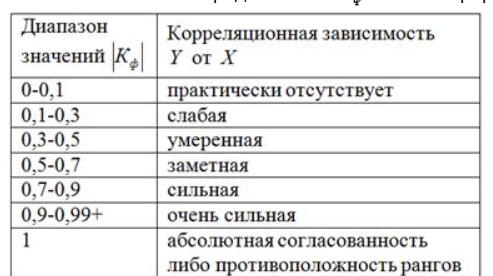
Корреляция очень сильная, причем обратная

Корреляция Пирсона с доверительным интервалом

In [41]:
def pearson_correlation(x, y):
    n = len(x)
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    covariance = 0
    for i in range(n):
        covariance += (x[i] - x_mean) * (y[i] - y_mean)
    covariance = covariance / (n - 1)
    
    std_x = 0
    std_y = 0
    for i in range(n):
        std_x += (x[i] - x_mean) ** 2
        std_y += (y[i] - y_mean) ** 2
    
    std_x = np.sqrt(std_x / (n - 1))
    std_y = np.sqrt(std_y / (n - 1))
    
    r = covariance / (std_x * std_y)
    return r

r_pearson = pearson_correlation(x, y)
print(f"Корреляция Пирсона: {r_pearson:.4f}")

Корреляция Пирсона: -0.9606


Аналогично получили ещё более близкий коэффициент корреляции к -1, а значит сильная обратная корреляция

Доверительный интервал для корреляции Пирсона

In [42]:
def pearson_interval(r, n, alpha=0.05):
    z = np.arctanh(r)
    z_se = 1 / np.sqrt(n - 3)
    
    z_critical = stats.norm.ppf(1 - alpha/2)
    
    z_lower = z - z_critical * z_se
    z_upper = z + z_critical * z_se
    
    r_lower = np.tanh(z_lower)
    r_upper = np.tanh(z_upper)
    
    return r_lower, r_upper

ci_pearson = pearson_interval(r_pearson, len(x))

print(f"Доверительный интервал Пирсона (95%): [{ci_pearson[0]:.4f}, {ci_pearson[1]:.4f}]")

Доверительный интервал Пирсона (95%): [-0.9846, -0.9012]


Это значит что с вероятностью 95% настоящая корреляция лежит в [-0.9846, -0.9012]. 
Также интервал не включает 0, а значит корреляция статистически значимая

Корреляция Спирмена

In [43]:
def spearman_correlation(x, y):
    n = len(x)
    def compute_ranks(data):
        indexed_data = [(value, idx) for idx, value in enumerate(data)]
        sorted_data = sorted(indexed_data, key=lambda x: x[0])
        
        ranks = [0] * n
        i = 0
        while i < n:
            j = i
            while j < n - 1 and sorted_data[j][0] == sorted_data[j + 1][0]:
                j += 1
            
            avg_rank = (i + j + 2) / 2
            
            for k in range(i, j + 1):
                original_idx = sorted_data[k][1]
                ranks[original_idx] = avg_rank
            
            i = j + 1
        
        return ranks
    
    ranks_x = compute_ranks(x)
    ranks_y = compute_ranks(y)
    
    return pearson_correlation(ranks_x, ranks_y)

r_spearman = spearman_correlation(x, y)
print(f"Корреляция Спирмена: {r_spearman:.4f}")


Корреляция Спирмена: -0.9849


Очень сильная обратная корреляция

Корреляция Кенделла

In [44]:
def kendall_correlation(x, y):
    n = len(x)
    concordant = 0
    discordant = 0
    
    for i in range(n - 1):
        for j in range(i + 1, n):
            if x[i] < x[j]:
                x_order = -1
            elif x[i] > x[j]:
                x_order = 1
            else:
                x_order = 0
            
            if y[i] < y[j]:
                y_order = -1
            elif y[i] > y[j]:
                y_order = 1
            else:
                y_order = 0
            
            if x_order * y_order > 0:
                concordant += 1
            elif x_order * y_order < 0:
                discordant += 1
    
    total_pairs = n * (n - 1) / 2
    tau = (concordant - discordant) / total_pairs
    return tau

tau_kendall = kendall_correlation(x, y)
print(f"Корреляция Кенделла: {tau_kendall:.4f}")


Корреляция Кенделла: -0.9316


Очень сильная обратная корреляция

## ВИЗУАЛИЗАЦИЯ

выведем гистограммы и scatter plot

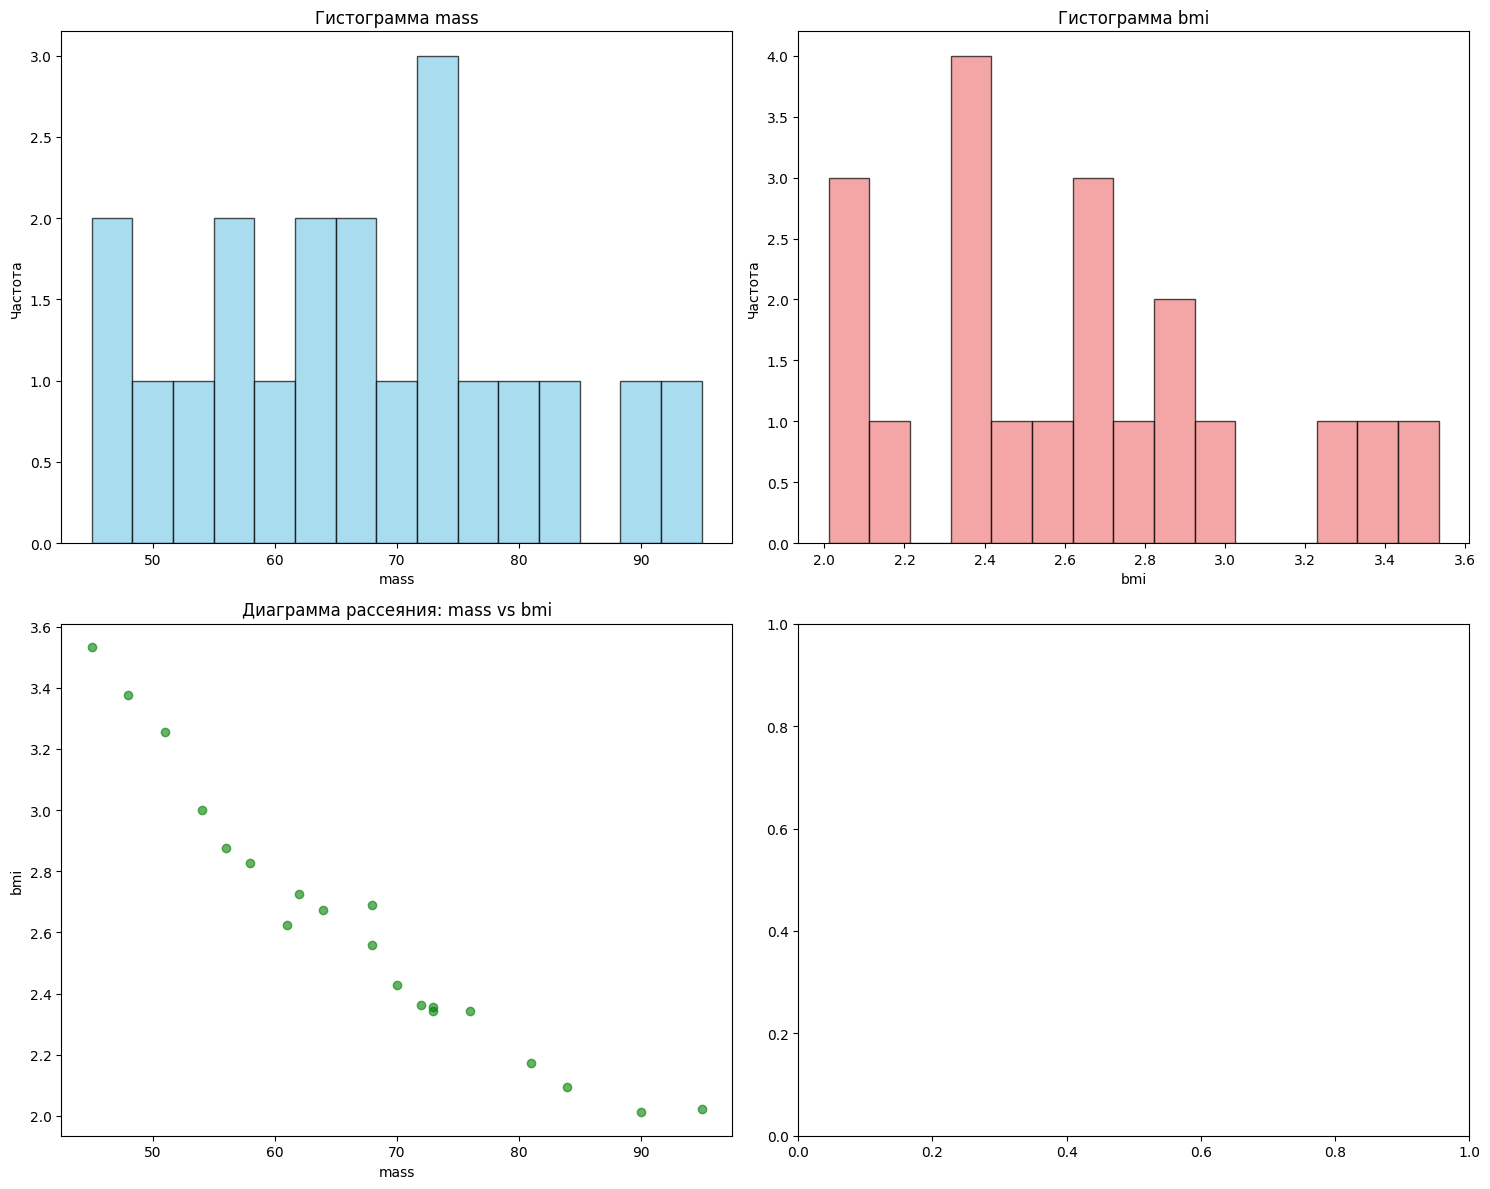

In [45]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].hist(x, bins=15, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title(f'Гистограмма {col1}')
axes[0, 0].set_xlabel(col1)
axes[0, 0].set_ylabel('Частота')

axes[0, 1].hist(y, bins=15, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0, 1].set_title(f'Гистограмма {col2}')
axes[0, 1].set_xlabel(col2)
axes[0, 1].set_ylabel('Частота')

axes[1, 0].scatter(x, y, alpha=0.6, color='green')
axes[1, 0].set_title(f'Диаграмма рассеяния: {col1} vs {col2}')
axes[1, 0].set_xlabel(col1)
axes[1, 0].set_ylabel(col2)

plt.tight_layout()
plt.show()


#### Наблюдается очевидная обратная корреляция

## Регрессии

1. Линейная регрессия

In [46]:
def linear_regression(x, y):
    n = len(x)
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    numerator = 0
    denominator = 0
    for i in range(n):
        numerator += (x[i] - x_mean) * (y[i] - y_mean)
        denominator += (x[i] - x_mean) ** 2
    
    w1 = numerator / denominator
    w0 = y_mean - w1 * x_mean
    
    y_pred = w1 * x + w0
    
    ss_res = 0
    ss_tot = 0
    for i in range(n):
        ss_res += (y[i] - y_pred[i]) ** 2
        ss_tot += (y[i] - y_mean) ** 2
    
    r2 = 1 - (ss_res / ss_tot)
    
    return w1, w0, y_pred, r2

w1_lin, w0_lin, y_pred_lin, r2_lin = linear_regression(x, y)
print(f"Линейная: y = {w1_lin:.4f}*x + {w0_lin:.4f}, R^2 = {r2_lin:.4f}")

Линейная: y = -0.0308*x + 4.6881, R^2 = 0.9228


2. Квадратичная регрессия

In [47]:
def quadratic_regression(x, y):
    x_reshaped = x.reshape(-1, 1)
    poly = PolynomialFeatures(degree=2)
    x_poly = poly.fit_transform(x_reshaped)
    model = LinearRegression()
    model.fit(x_poly, y)
    y_pred = model.predict(x_poly)
    
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    return model.coef_[2], model.coef_[1], model.intercept_, y_pred, r2

w2_quad, w1_quad, w0_quad, y_pred_quad, r2_quad = quadratic_regression(x, y)
print(f"Квадратичная: y = {w2_quad:.4f}*x² + {w1_quad:.4f}*x + {w0_quad:.4f}, R^2 = {r2_quad:.4f}")


Квадратичная: y = 0.0005*x² + -0.0990*x + 6.9596, R^2 = 0.9779


3. Гиперболическая регрессия

In [48]:
def hyperbolic_regression(x, y):
    x_transformed = 1 / x
    w1, w0, y_pred, r2 = linear_regression(x_transformed, y)
    return w1, w0, y_pred, r2

w1_hyp, w0_hyp, y_pred_hyp, r2_hyp = hyperbolic_regression(x, y)
print(f"Гиперболическая: y = {w1_hyp:.4f}/x + {w0_hyp:.4f}, R^2 = {r2_hyp:.4f}")

Гиперболическая: y = 135.2427/x + 0.5275, R^2 = 0.9791


4. Показательная регрессия

In [49]:
def exponential_regression(x, y):
    # y = w0 * w1^x -> ln(y) = ln(w0) + x*ln(w1)
    y_transformed = np.log(y)
    w1_log, w0_log, y_pred_transformed, r2_log = linear_regression(x, y_transformed)
    
    w1 = np.exp(w1_log)
    w0 = np.exp(w0_log)
    y_pred = np.exp(y_pred_transformed)
    
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    return w1, w0, y_pred, r2

w1_exp, w0_exp, y_pred_exp, r2_exp = exponential_regression(x, y)
print(f"Показательная: y = {w0_exp:.4f} * {w1_exp:.4f}^x, R^2 = {r2_exp:.4f}")

Показательная: y = 5.6857 * 0.9884^x, R^2 = 0.9542


### В каждом уравнении регрессии получили высокий R^2, а значит что в целом каждое из уравнений регрессии очень хорошо ложится на выборку (X, Y)

## Графики регрессионных уравнений

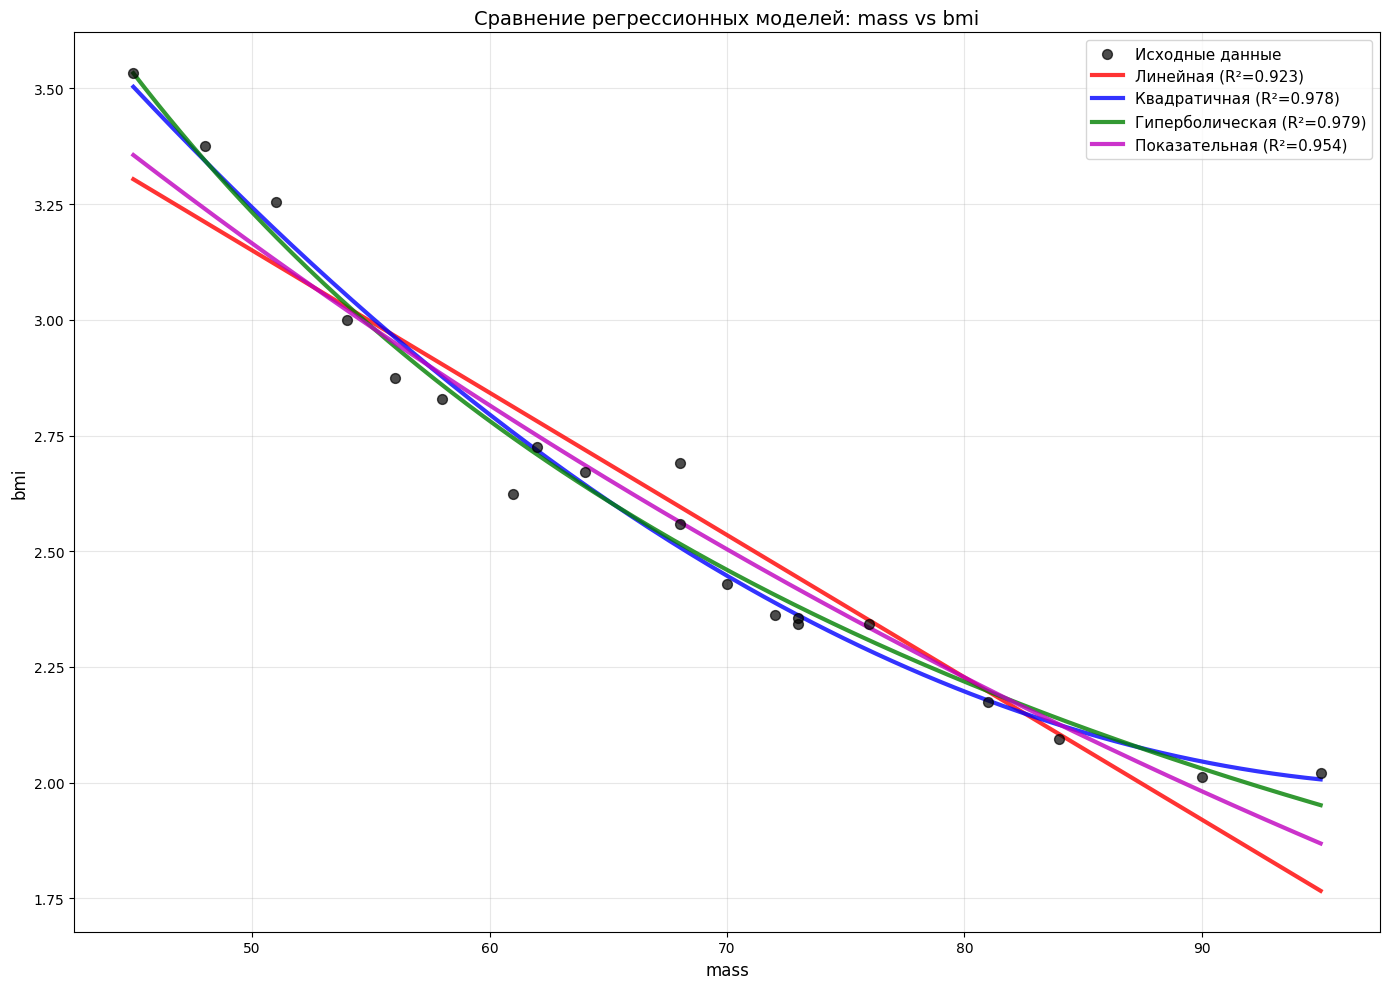

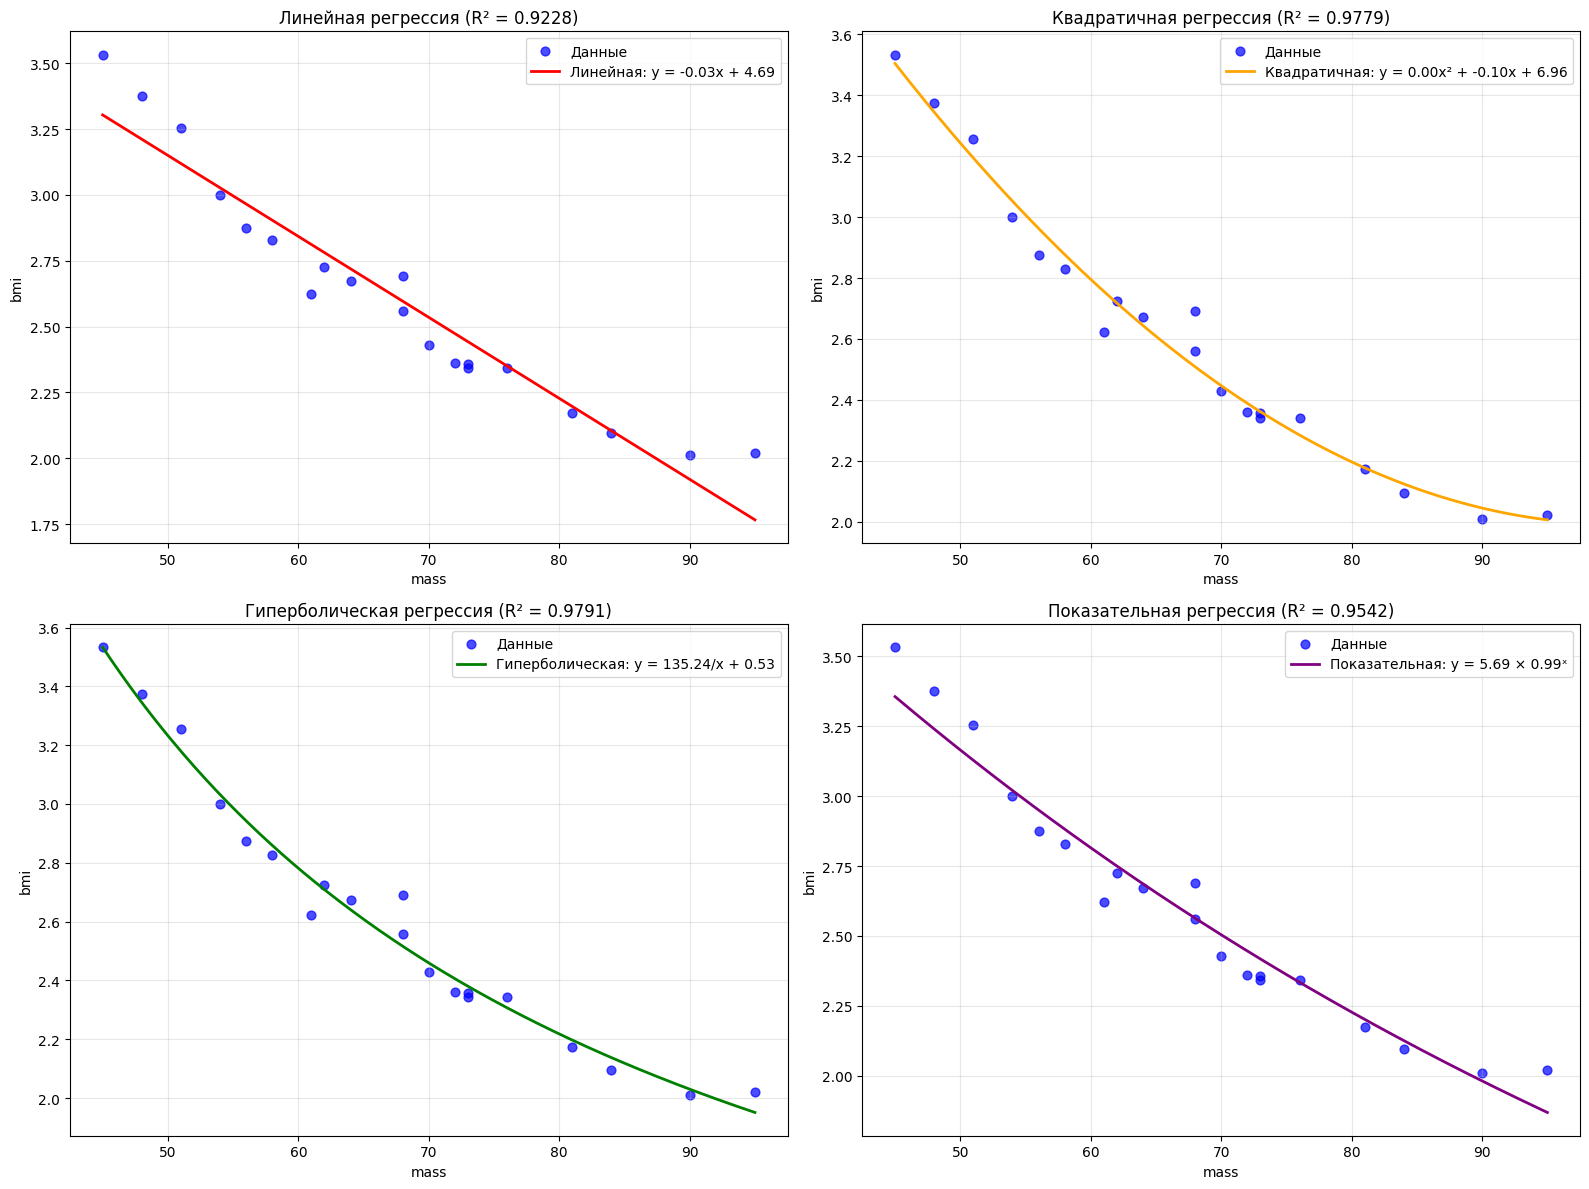

In [53]:
x_smooth = np.linspace(x.min(), x.max(), 300)

plt.figure(figsize=(14, 10))

plt.scatter(x, y, alpha=0.7, color='black', s=50, label='Исходные данные', zorder=5)

y_lin_smooth = w1_lin * x_smooth + w0_lin
plt.plot(x_smooth, y_lin_smooth, 'r-', linewidth=3, 
         label=f'Линейная (R²={r2_lin:.3f})', alpha=0.8)

y_quad_smooth = w2_quad * x_smooth**2 + w1_quad * x_smooth + w0_quad
plt.plot(x_smooth, y_quad_smooth, 'b-', linewidth=3, 
         label=f'Квадратичная (R²={r2_quad:.3f})', alpha=0.8)

x_hyp_smooth = x_smooth[x_smooth != 0]
y_hyp_smooth = w1_hyp / x_hyp_smooth + w0_hyp
plt.plot(x_hyp_smooth, y_hyp_smooth, 'g-', linewidth=3, 
         label=f'Гиперболическая (R²={r2_hyp:.3f})', alpha=0.8)

y_exp_smooth = w0_exp * (w1_exp ** x_smooth)
plt.plot(x_smooth, y_exp_smooth, 'm-', linewidth=3, 
         label=f'Показательная (R²={r2_exp:.3f})', alpha=0.8)

plt.xlabel(col1, fontsize=12)
plt.ylabel(col2, fontsize=12)
plt.title(f'Сравнение регрессионных моделей: {col1} vs {col2}', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].scatter(x, y, alpha=0.7, color='blue', s=40, label='Данные')
axes[0, 0].plot(x_smooth, y_lin_smooth, 'r-', linewidth=2, 
                label=f'Линейная: y = {w1_lin:.2f}x + {w0_lin:.2f}')
axes[0, 0].set_xlabel(col1)
axes[0, 0].set_ylabel(col2)
axes[0, 0].set_title(f'Линейная регрессия (R² = {r2_lin:.4f})', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].scatter(x, y, alpha=0.7, color='blue', s=40, label='Данные')
axes[0, 1].plot(x_smooth, y_quad_smooth, 'orange', linewidth=2, 
                label=f'Квадратичная: y = {w2_quad:.2f}x² + {w1_quad:.2f}x + {w0_quad:.2f}')
axes[0, 1].set_xlabel(col1)
axes[0, 1].set_ylabel(col2)
axes[0, 1].set_title(f'Квадратичная регрессия (R² = {r2_quad:.4f})', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].scatter(x, y, alpha=0.7, color='blue', s=40, label='Данные')
axes[1, 0].plot(x_hyp_smooth, y_hyp_smooth, 'green', linewidth=2, 
                label=f'Гиперболическая: y = {w1_hyp:.2f}/x + {w0_hyp:.2f}')
axes[1, 0].set_xlabel(col1)
axes[1, 0].set_ylabel(col2)
axes[1, 0].set_title(f'Гиперболическая регрессия (R² = {r2_hyp:.4f})', fontsize=12)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].scatter(x, y, alpha=0.7, color='blue', s=40, label='Данные')
axes[1, 1].plot(x_smooth, y_exp_smooth, 'purple', linewidth=2, 
                label=f'Показательная: y = {w0_exp:.2f} × {w1_exp:.2f}ˣ')
axes[1, 1].set_xlabel(col1)
axes[1, 1].set_ylabel(col2)
axes[1, 1].set_title(f'Показательная регрессия (R² = {r2_exp:.4f})', fontsize=12)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Графики подтвердили вышесказанное: все уравнения регрессии хорошо ложаться на (X, Y)
В линейной регрессии все таки есть сильные расхождения на концах, лучше всего объясняет (X, Y) именно гиперболическая и квадратичная регрессия

## ПРОВЕРКА ЗНАЧИМОСТИ РЕГРЕССИИ с помощью критерия Фишера

In [50]:
def fisher_test(r2, n, k, alpha=0.05):
    F = (r2 / (1 - r2)) * ((n - k) / (k - 1))
    
    df1 = k - 1
    df2 = n - k
    F_critical = stats.f.ppf(1 - alpha, df1, df2)
    p_value = 1 - stats.f.cdf(F, df1, df2)
    
    return F, F_critical, p_value

models_r2 = {
    'Линейная': r2_lin,
    'Квадратичная': r2_quad,
    'Гиперболическая': r2_hyp,
    'Показательная': r2_exp
}

best_model = max(models_r2, key=models_r2.get)
worst_model = min(models_r2, key=models_r2.get)

print(f"Лучшая модель: {best_model} (R^2 = {models_r2[best_model]:.4f})")
print(f"Худшая модель: {worst_model} (R^2 = {models_r2[worst_model]:.4f})")

k_params = {
    'Линейная': 2,
    'Квадратичная': 3,
    'Гиперболическая': 2,
    'Показательная': 2
}

k_best = k_params[best_model]
F_best, F_crit_best, p_best = fisher_test(models_r2[best_model], len(x), k_best)
print(f"\nЛучшая модель ({best_model}):")
print(f"F-статистика = {F_best:.4f}")
print(f"Критическое значение F = {F_crit_best:.4f}")
print(f"p-значение = {p_best:.4f}")

k_worst = k_params[worst_model]
F_worst, F_crit_worst, p_worst = fisher_test(models_r2[worst_model], len(x), k_worst)
print(f"\nХудшая модель ({worst_model}):")
print(f"F-статистика = {F_worst:.4f}")
print(f"Критическое значение F = {F_crit_worst:.4f}")
print(f"p-значение = {p_worst:.4f}")

Лучшая модель: Гиперболическая (R^2 = 0.9791)
Худшая модель: Линейная (R^2 = 0.9228)

Лучшая модель (Гиперболическая):
F-статистика = 844.5955
Критическое значение F = 4.4139
p-значение = 0.0000

Худшая модель (Линейная):
F-статистика = 215.0718
Критическое значение F = 4.4139
p-значение = 0.0000


В обоих случаях F-статистика сильно больше, чем Критическое значение, а p-value = 0 < alpha = 0.05, исходя из этого обе модели являются статистически значимыми.
Также лучшее уравнение (Гиперболическое) показало F-статистику сильно большую чем F-статистика линейного (худшего), что тоже кажется логичным. 